In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn import metrics
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


### Reading Training data

In [2]:
df1=pd.read_csv("./processed/training/engaged.csv")
df2=pd.read_csv("./processed/training/notEngaged.csv")
dff=pd.read_csv("./TopFeatures.csv")

In [3]:
dft=pd.concat([df1,df2])

In [4]:
feat=dff.to_numpy()
feat=feat.reshape(-1)

In [5]:
print(feat)

[' AU12_c' ' AU04_c' ' AU04_r' ' AU12_r' ' AU05_c' ' AU14_c' ' AU06_c'
 ' AU10_c' ' AU14_r' ' p_2' ' AU06_r' ' p_8' ' AU07_r' ' AU10_r' ' p_0'
 ' p_10' ' p_7' ' p_6' ' AU01_r' ' p_23' ' p_12' ' AU26_r' ' AU25_r'
 ' p_5' ' AU45_r' ' p_20' ' AU09_r' ' AU17_r' ' p_24' ' p_9' ' AU05_r'
 ' p_11' ' p_18' ' AU15_c' ' p_16' ' AU23_r' ' p_27' ' p_3' ' p_13'
 ' p_26' ' AU02_r' ' p_15' ' p_19' ' p_21' ' AU20_r' ' AU15_r' ' p_30'
 ' p_1' ' gaze_1_z' ' p_31']


In [6]:
y_train=dft["Result"]
x_train=dft.drop("Result",axis=1)
x_train=x_train[feat]

In [7]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(x_train)
x_train = model.transform(x_train)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.25)

In [9]:
X_train

array([[-0.3704943 , -0.32406061,  0.15096188, ...,  0.28227591,
         0.58808412,  0.47631616],
       [-0.3704943 , -0.32406061,  2.97701068, ...,  1.84880735,
         1.60879515, -0.32362949],
       [-0.3704943 , -0.32406061, -0.54826669, ..., -0.76237862,
        -0.34526768,  0.14300547],
       ...,
       [-0.3704943 , -0.32406061, -0.37345955, ..., -0.11440098,
         0.46687431, -0.22363628],
       [-0.3704943 , -0.32406061, -0.8104774 , ...,  2.12226581,
         0.53194833, -0.25696735],
       [-0.3704943 ,  3.08584246,  0.76278688, ..., -1.11600112,
        -0.37788018,  0.34299189]])

In [10]:
model=tree.DecisionTreeClassifier(class_weight="balanced")

### Training of the given model

In [11]:
model = model.fit(X_train, Y_train)

In [12]:
target_names = ['Not Engaged','Engaged']
claf_report=classification_report(Y_test,model.predict(X_test),target_names=target_names,output_dict=True)
print(claf_report)

{'Not Engaged': {'precision': 0.6389001213101496, 'recall': 0.6435845213849287, 'f1-score': 0.6412337662337664, 'support': 2455}, 'Engaged': {'precision': 0.7122657020716869, 'recall': 0.7080745341614907, 'f1-score': 0.7101639344262295, 'support': 3059}, 'accuracy': 0.6793616249546609, 'macro avg': {'precision': 0.6755829116909182, 'recall': 0.6758295277732097, 'f1-score': 0.6756988503299979, 'support': 5514}, 'weighted avg': {'precision': 0.6796011208657432, 'recall': 0.6793616249546609, 'f1-score': 0.6794741333902308, 'support': 5514}}


In [13]:
helix=pd.read_csv("./TopFeatures.csv")
h2=pd.read_csv("./heatMaps.csv")
helix['value']=h2
#print(helix)
helix.to_csv("Finalmaps.csv",index=None,header=None)

g1=pd.read_csv("./Finalmaps.csv",index_col=None)
h6=helix['value'].to_numpy()
h6=np.reshape(h6, (50, 1)) # C-like index ordering
#print(h6)

## HeatMap

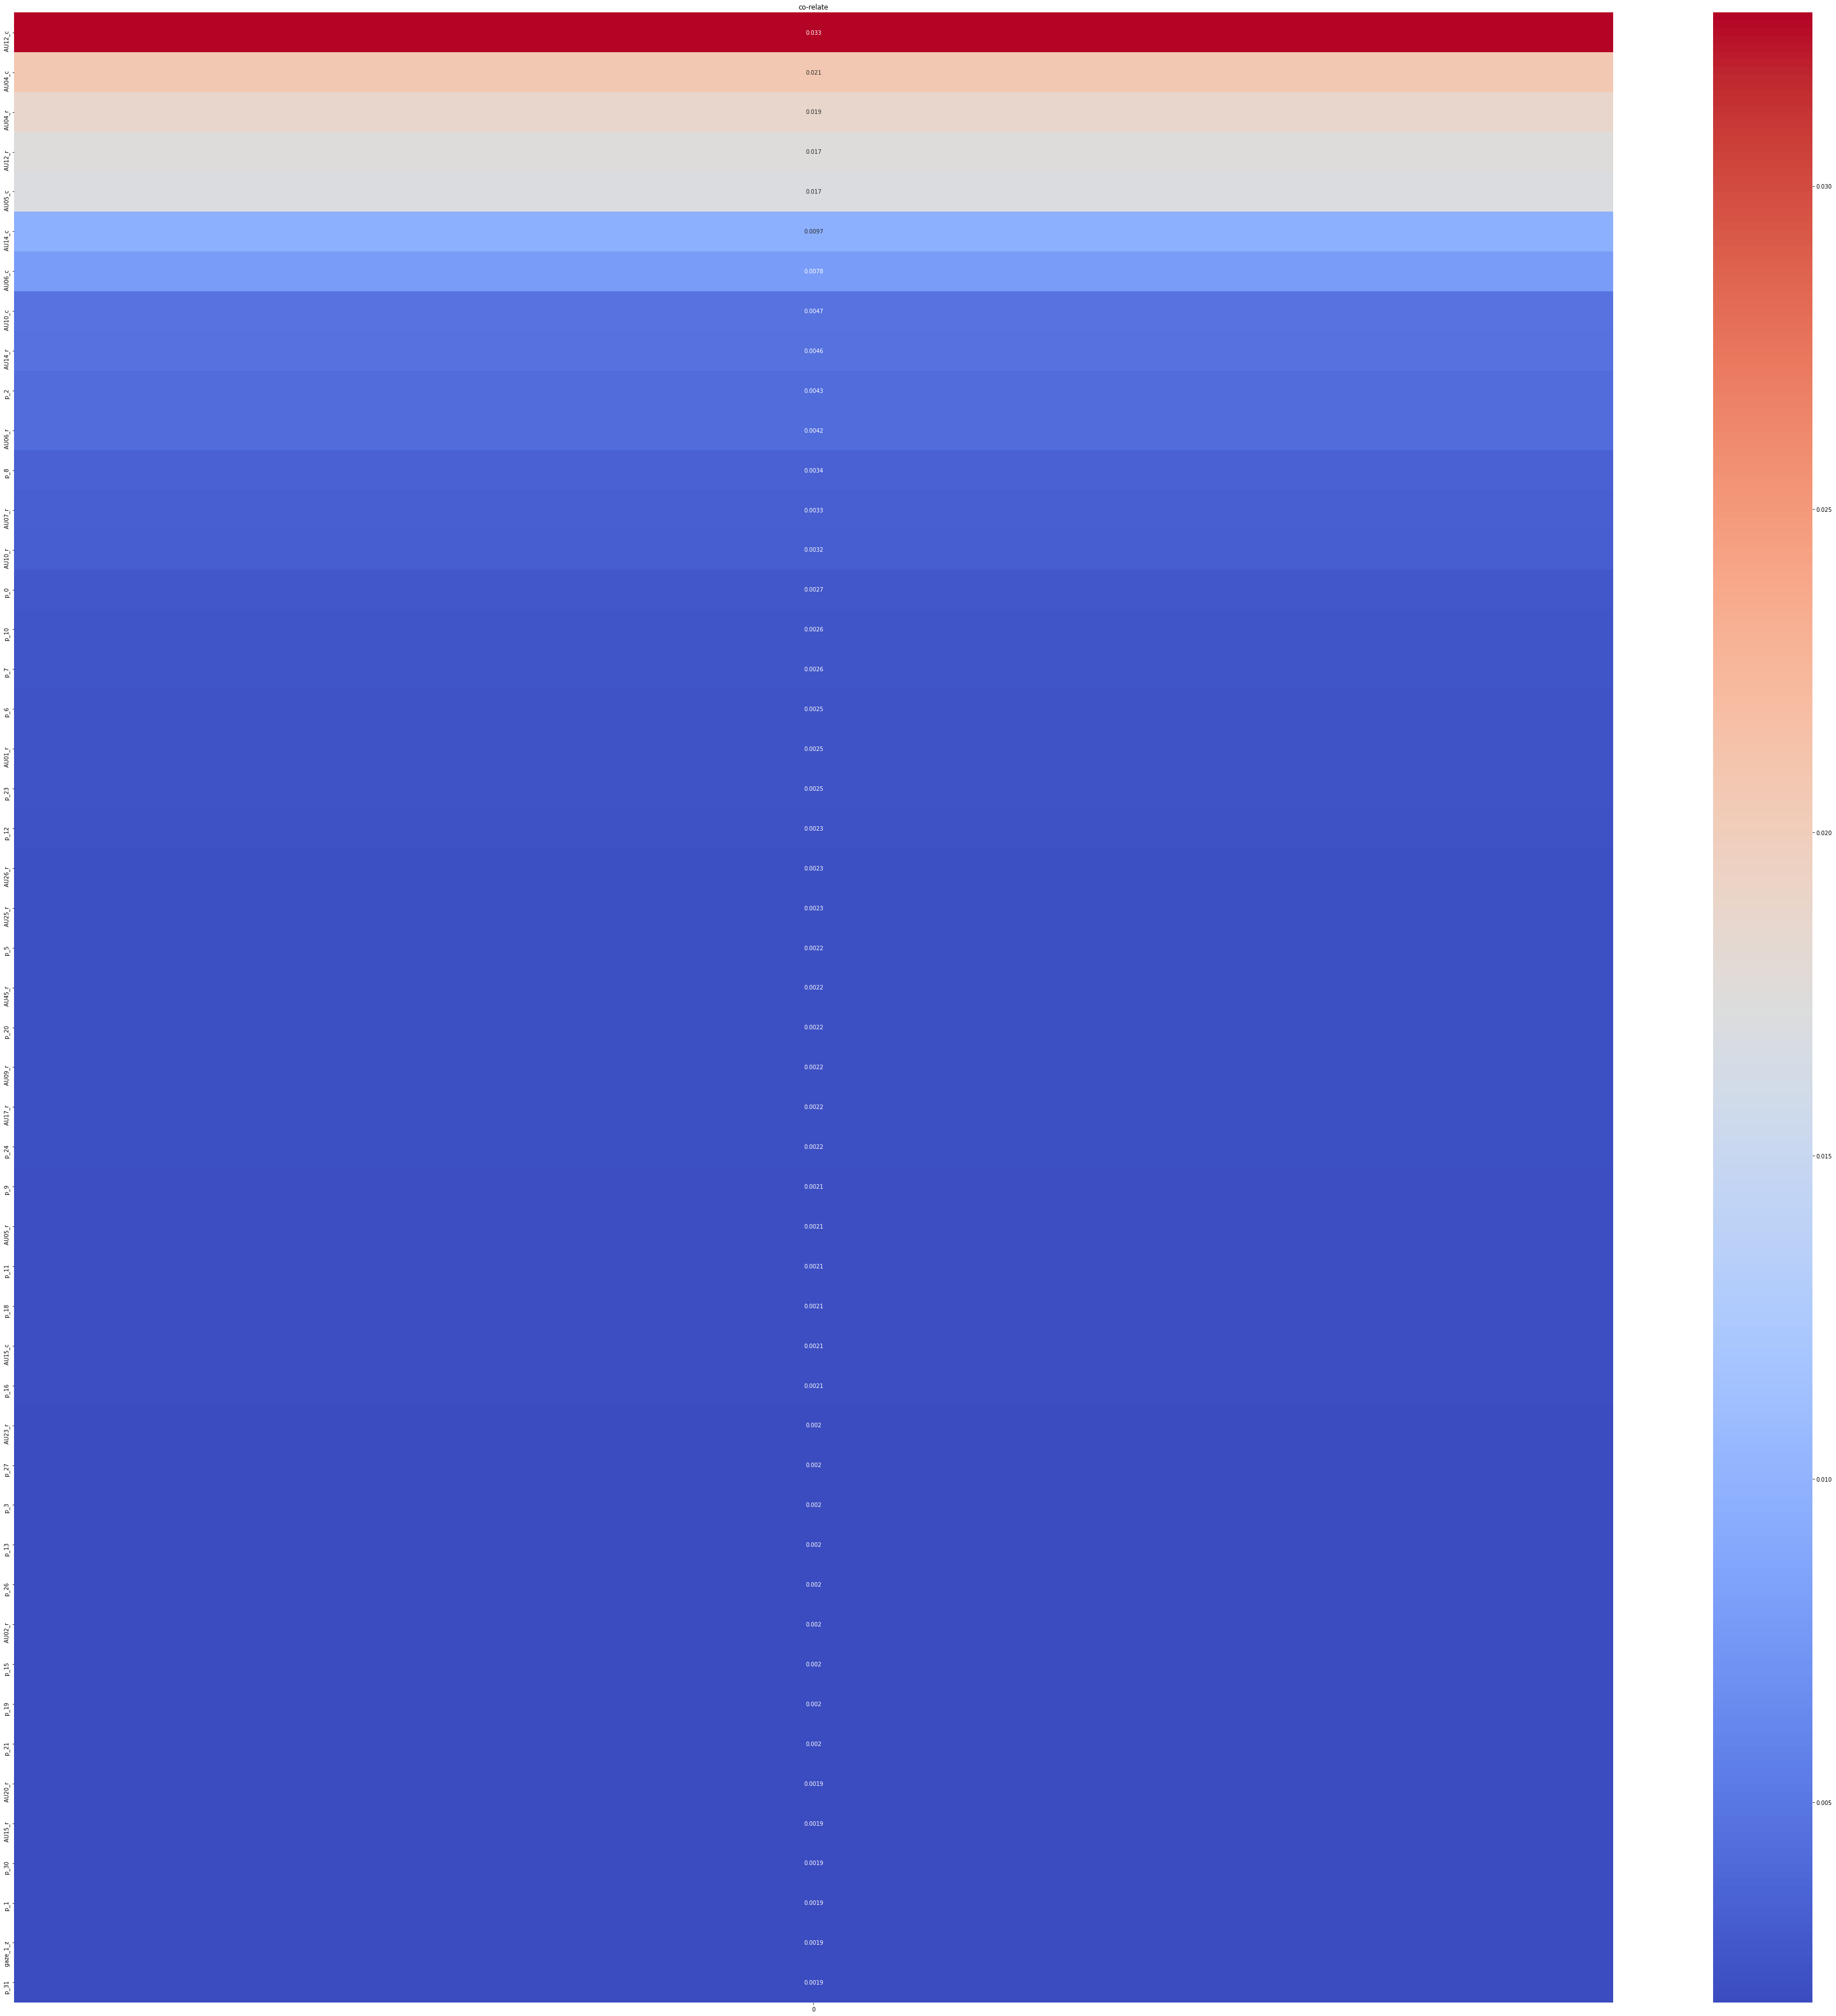

In [14]:
plt.figure(figsize=(50,50))

ax=sns.heatmap(h6, annot=True, cmap="coolwarm", yticklabels=helix['0']).set_title('co-relate')
plt.tight_layout()
plt.show()

<AxesSubplot:>

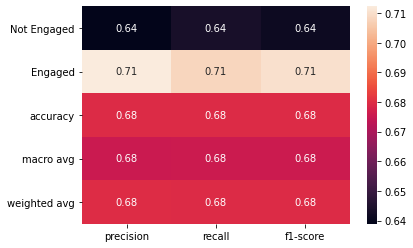

In [15]:
sns.heatmap(pd.DataFrame(claf_report).iloc[:-1, :].T, annot=True)

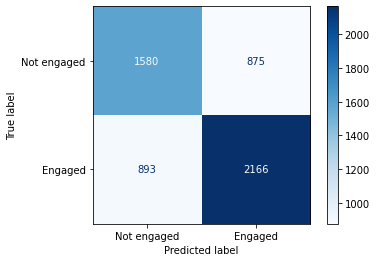

In [16]:
metrics.plot_confusion_matrix(model, X_test, Y_test, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'])

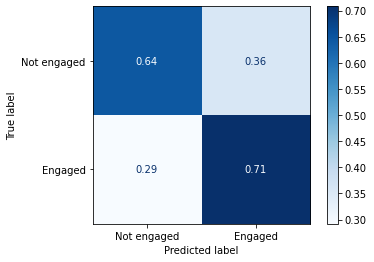

In [17]:
metrics.plot_confusion_matrix(model, X_test, Y_test, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'], normalize='true')

### Fitting the model on complete data

In [18]:
model = model.fit(x_train, y_train)

### Saving the Model

In [19]:
patho=r'./models'
joblib.dump(model, (os.path.join(patho,r''+'model_joblib_decision_tree')))

['./models/model_joblib_decision_tree']

In [20]:
plt.close()

In [21]:
tree.export_graphviz(model,
                     out_file="tree.dot",
                     feature_names = feat, 
                     class_names=["Not Engaged","Engaged"],
                     filled = True)